In [70]:
%pylab inline
import pandas as pd
import os
import scipy.stats

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Paths
DATADIR="/storage/mgymrek/chipmunk/fig1_eval"
OUTDIR=os.path.join(DATADIR, "pdfs")

FIG1COLOR = "darkblue"


Populating the interactive namespace from numpy and matplotlib


In [88]:
#factor = "GM12878_MEF2A_ENCFF359HKJ_ENCFF980AUY"
#factor2 = "GM12878_MEF2A_ENCFF012YAB_ENCFF951TLZ"
factor = "GM12878_H3K27ac_ENCFF097SQI_ENCFF465WTH"
factor2 = "GM12878_H3K27ac_ENCFF385RWJ_ENCFF849JNQ"
binsize=5

(0.7320705324679294, 0.0)
(0.7735049944386491, 0.0)
0.9819878766688265


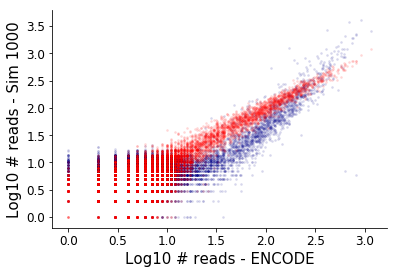

In [89]:
nc = 1000
enc_bins = pd.read_csv(os.path.join(DATADIR, factor, factor+".ENCODE.cov.%skb.bed"%binsize), usecols=[1,2,3], names=["pos","end","enc.counts"], sep="\t")
enc_bins2 = pd.read_csv(os.path.join(DATADIR, factor2, factor2+".ENCODE.cov.%skb.bed"%binsize), usecols=[3], names=["enc2.counts"], sep="\t")

sim_bins = pd.read_csv(os.path.join(DATADIR, factor, factor+".%s.cov.%skb.bed"%(nc, binsize)), usecols=[3], names=["sim.counts"], sep="\t")
bindata = pd.DataFrame({"pos": enc_bins["pos"], "end":enc_bins["end"], \
                        "enc.counts": enc_bins["enc.counts"], "enc2.counts": enc_bins2["enc2.counts"], \
                        "sim.counts": sim_bins["sim.counts"]})

bindata = bindata[bindata["enc.counts"]+bindata["sim.counts"]>0]


# remove outliers. kosher?
#bindata = bindata[(bindata["sim.counts"]<500) & (bindata["enc.counts"]<500)]

fig = plt.figure()
ax = fig.add_subplot(111)
pc = 1
ax.scatter(np.log10(bindata["enc.counts"]+pc), np.log10(bindata["sim.counts"]+pc), s=3, color=FIG1COLOR, alpha=0.1);
ax.scatter(np.log10(bindata["enc.counts"]+pc), np.log10(bindata["enc2.counts"]+pc), s=3, color="red", alpha=0.1);

ax.set_xlabel("Log10 # reads - ENCODE", size=15)
ax.set_ylabel("Log10 # reads - Sim %s"%nc, size=15)
ax.set_xticklabels(["%0.1f"%item for item in ax.get_xticks()], size=12)
ax.set_yticklabels(["%0.1f"%item for item in ax.get_yticks()], size=12);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
print(scipy.stats.pearsonr(np.log10(bindata["enc.counts"]+pc), np.log10(bindata["sim.counts"]+pc)))
print(scipy.stats.pearsonr((bindata["enc.counts"]), (bindata["sim.counts"])))
bindata.apply(sum)
rep_cor=(scipy.stats.pearsonr(bindata["enc.counts"], bindata["enc2.counts"])[0])
print(rep_cor)
#fig.savefig(os.path.join(OUTDIR, "SuppFig_BinsExample.pdf"))

In [97]:
# Look at model as a function of cell number
ncs = [1, 5, 10, 25, 50, 100, 1000, 10000]
import json
actual = json.load(open(os.path.join("/storage/mgymrek/chipmunk/encode", factor, "%s.json"%(factor))))
print("NumCells\tLearnedFromReal-s\tLearnFromSim-s")
for nc in ncs:
    model = json.load(open(os.path.join(DATADIR, factor, "%s.%s.json.json"%(factor, nc)), "r"))
    print("%s\t%s\t%s"%(nc, actual["pulldown"]["s"], model["pulldown"]["s"]))

NumCells	LearnedFromReal-s	LearnFromSim-s
1	0.5064640045166016	0.2534857988357544
5	0.5064640045166016	0.5250022411346436
10	0.5064640045166016	0.594392716884613
25	0.5064640045166016	0.6456980109214783
50	0.5064640045166016	0.663651704788208
100	0.5064640045166016	0.6688878536224365
1000	0.5064640045166016	0.6689351201057434
10000	0.5064640045166016	0.6693905591964722


In [73]:
bindata["coord"] = bindata.apply(lambda x: "chr19:%s-%s"%(x["pos"], x["end"]), 1)
bindata.sort_values("enc.counts").head()

,enc.counts,enc2.counts,end,pos,sim.counts,coord
6241,0,5,31210000,31205000,5,chr19:31205000-31210000
8426,0,7,42135000,42130000,9,chr19:42130000-42135000
1737,0,0,8690000,8685000,2,chr19:8685000-8690000
11411,0,2,57060000,57055000,5,chr19:57055000-57060000
1768,0,2,8845000,8840000,10,chr19:8840000-8845000


The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


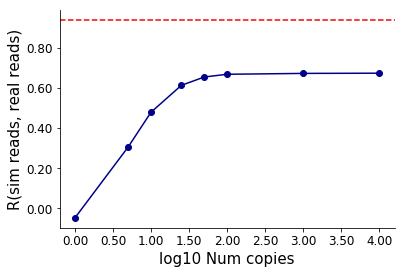

In [81]:
# get corr for different cell nums
enc_bins = pd.read_csv(os.path.join(DATADIR, factor, factor+".ENCODE.cov.%skb.bed"%binsize), usecols=[3], names=["enc.counts"], sep="\t")

ncs = [1, 5, 10, 25, 50, 100, 1000, 10000] #, 50, 75, 100, 1000, 10000]
rvals = []
for nc in ncs:
    sim_bins = pd.read_csv(os.path.join(DATADIR, factor, factor+".%s.cov.%skb.bed"%(nc, binsize)), usecols=[3], names=["sim.counts"], sep="\t")
    bindata = pd.DataFrame({"enc.counts": enc_bins["enc.counts"], "sim.counts": sim_bins["sim.counts"]})

    bindata = bindata[bindata["enc.counts"]+bindata["sim.counts"]>0]

    # remove outliers. kosher?
    bindata = bindata[(bindata["sim.counts"]<500) & (bindata["enc.counts"]<500)]

    r = scipy.stats.pearsonr((bindata["enc.counts"]), (bindata["sim.counts"]))[0]
    rvals.append(r)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.log10(ncs), rvals, color=FIG1COLOR, marker="o");
ax.axhline(y=rep_cor, color="red", linestyle="dashed")
ax.set_xlabel("log10 Num copies", size=15)
ax.set_ylabel("R(sim reads, real reads)", size=15)
ax.set_xticklabels(["%0.2f"%item for item in ax.get_xticks()], size=12)
ax.set_yticklabels(["%0.2f"%item for item in ax.get_yticks()], size=12);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#fig.savefig(os.path.join(OUTDIR, "SuppFig_BinsExample_vsNC.pdf"))